# 实战 Kaggle 比赛：图像分类 (CIFAR-10)

比赛的网址是https://www.kaggle.com/c/cifar-10

In [1]:
%matplotlib inline
import collections
import math
import os
import glob
import shutil
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip
from torchvision.datasets import ImageFolder
from torchvision.models.resnet import load_state_dict_from_url
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
from d2l import torch as d2l

我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

读取数据集标签

In [3]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
# TASK 1.1 （5分）输出数据集中都有哪些类
# TASK 1.2 （5分）输出数据集中的图片总数
label_names = list(np.unique(list(labels.values())))
label_names.sort()
print(f"=> 所有类别：{label_names}")
print(f"=> 总图片数：{len(labels)}")

=> 所有类别：['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
=> 总图片数：1000


从数据集中拆分出训练集和验证集

In [4]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)
    return labels

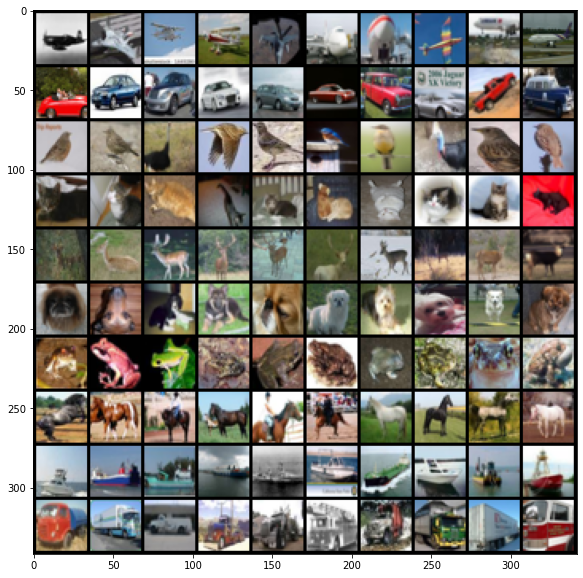

In [5]:
# TASK 2.1 （5分）建立cifar10数据集，并使用20%数据作为验证集。在注释中解释函数的参数代表的意义。

labels = reorg_cifar10_data(data_dir, 0.2)

# TASK 2.2 （15分）展示*训练集*所有类别的前10张图片。类别按照字母顺序进行*排序*，并将他们*放在同一张*大图中进行展示。
# 每一行代码都需要写好*注释*，表明该行代码的作用。如果你调用了numpy/torch的函数，请在注释中*解释参数*的意义。
# 提示：请仔细阅读 reorg_cifar10_data, reorg_train_valid, reorg_test 函数的定义。
viz_fpaths = []
for label_name in label_names:
    imfiles = glob.glob(f"{data_dir}/train_valid_test/train/{label_name}/*.png")
    imfiles.sort()
    viz_fpaths.extend(imfiles[:10])

def open_image_as_tensor(fp):
    image = np.asarray(Image.open(open(fp, "rb")))
    return torch.from_numpy(image).permute(2, 0, 1)
    
viz_images = torch.stack([open_image_as_tensor(fp) for fp in viz_fpaths])
disp_image = vutils.make_grid(viz_images, nrow=10).numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(disp_image)

图像增广

In [6]:
transform_train = Compose([
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize([0.4914, 0.4822, 0.4465],
              [0.2023, 0.1994, 0.2010])])

transform_test = Compose([
    ToTensor(),
    Normalize([0.4914, 0.4822, 0.4465],
              [0.2023, 0.1994, 0.2010])])

读取由原始图像组成的数据集

In [7]:
train_ds, train_valid_ds = [ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

指定上面定义的所有图像增广操作

In [8]:
batch_size = 32
train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, drop_last=True)

# TASK 3.1 （5分）定义验证集和测试集的DataLoader，并以val_dl和test_dl命名
val_dl = DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_dl =  DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

模型

In [9]:
# TASK 3.2 (25分) 请定义resnet18网络
# 要求：可以参考torchvision中的实现，但*不能*调用任何torchvision的类或函数。
# 只能使用torch.nn的模块构建，以练习手动搭建网络的基本功。
# 请注意，你的神经网络层名字需要与torchvision一致，否则后面无法导入预训练模型

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, padding=dilation, stride=stride, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


def _make_layer(block, inplanes, planes, blocks, stride=1, dilate=False):
    norm_layer = nn.BatchNorm2d
    downsample = None
    previous_dilation, dilation = 1, 1
    if dilate:
        dilation *= stride
        stride = 1
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv2d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
            norm_layer(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample, 1, 64, previous_dilation, norm_layer))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes, groups=1,
                            base_width=64, dilation=1,
                            norm_layer=norm_layer))

    return nn.Sequential(*layers)


def my_resnet18(n_class):
    """Build a ResNet18.
    Args:
        n_class: The number of output classes.
    Returns:
        The ResNet18.
    """
    inplanes = 64
    conv1 = nn.Conv2d(3, inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    bn1 = nn.BatchNorm2d(inplanes)
    relu = nn.ReLU(inplace=True)
    maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    layer1 = _make_layer(BasicBlock, 64, 64, 2)
    layer2 = _make_layer(BasicBlock, 64, 128, 2, stride=2, dilate=False)
    layer3 = _make_layer(BasicBlock, 128, 256, 2, stride=2, dilate=False)
    layer4 = _make_layer(BasicBlock, 256, 512, 2, stride=2, dilate=False)
    avgpool = nn.AdaptiveAvgPool2d((1, 1))
    flatten_layer = nn.Flatten(1)
    fc = nn.Linear(512 * BasicBlock.expansion, 1000)
    net = nn.Sequential(collections.OrderedDict([
        ("conv1", conv1),
        ("bn1", bn1),
        ("relu", relu),
        ("maxpool", maxpool),
        ("layer1", layer1),
        ("layer2", layer2),
        ("layer3", layer3),
        ("layer4", layer4),
        ("avgpool", avgpool),
        ("flatten", flatten_layer),
        ("fc", fc)]))
    state_dict = load_state_dict_from_url("https://download.pytorch.org/models/resnet18-f37072fd.pth")
    net.load_state_dict(state_dict)
    net.fc = nn.Linear(512 * BasicBlock.expansion, n_class)
    return net

net = my_resnet18(len(label_names))
# 建议先使用下方语句，其他都完成后再回过头来完成 TASK 3.2
# 如果你放弃TASK 3.2，那么你可以使用这行语句，否则请使用上面的my_resnet18构建网络
# net = d2l.resnet18(10, 3) 

训练函数

In [10]:
def train(net, train_dl, val_dl, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches = len(train_dl)
    timer = d2l.Timer()
    legend = ['train loss', 'train acc']
    if val_dl is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (x, y) in enumerate(train_dl):
            timer.start()
            optimizer.zero_grad()
            
            # TASK 4.1 （10分）完成网络的前传、后传。请用注释给出每一个语句的意义。
            pred = net(x)
            loss = criterion(pred, y)
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            # TASK 4.2 (5分) 计算对于此次数据x，有多少个样例被分对了，并将之记录进count中
            count = (pred.argmax(1) == y).float().sum()
            
            metric.add(loss, count, y.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if val_dl is not None:
            val_acc = d2l.evaluate_accuracy_gpu(net, val_dl)
            animator.add(epoch + 1, (None, None, val_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {val_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

NameError: name 'valid_iter' is not defined

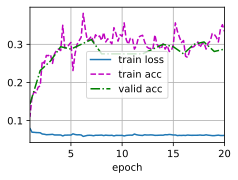

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay = 4, 0.9

# TASK 4.4 (5分) 在注释中给出每一个参数的意义
train(net, train_dl, val_dl, num_epochs, lr, wd, devices, lr_period,
      lr_decay)
# TASK 4.5 (20分) 请训练网络并保存loss、accuracy图像。

对测试集进行分类并提交结果

In [ ]:
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)